# TP1 - Problema da galeria de arte

## Integrantes do grupo


*   Antônio Caetano Neves Neto
*   Beatriz Reis Gama Barbosa
*   João Lucas Simões Moreira





## Importações e entrada

In [12]:
import numpy as np
import networkx as nx
import matplotlib.animation
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Número de vértices: 20


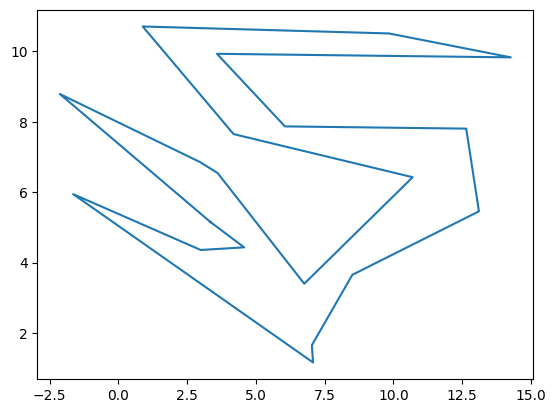

In [13]:
filename = 'polygons/superman.pol'
coordinates = []
X = []
Y = []

with open(filename, 'r') as file:
  text = file.read()
  try:
    words = text.split("\n")
    qtd = int(words[0])

    for i in range(qtd):
      x, y, nil = words[i+1].split(' ')
      x1, x2 = x.split('/')
      y1, y2 = y.split('/')
      x = float(x1)/float(x2)
      y = float(y1)/float(y2)
      X.append(x)
      Y.append(y)
      coordinates.append((x,y))
      
  except:
      words = text.split(" ")
      qtd = int(words[0])

      for i in range(qtd):
        x, y = words[i*2+1], words[i*2+2]

        x1, x2 = x.split('/')
        y1, y2 = y.split('/')
        x = float(x1)/float(x2)
        y = float(y1)/float(y2)
        X.append(x)
        Y.append(y)
        coordinates.append((x,y))

print(f"Número de vértices: {len(coordinates)}")
plt.plot(X + [X[0]], Y + [Y[0]])
plt.show()

## Triangulação de polígonos

### Funções auxiliares

In [14]:
def is_convex(a, b, c):
  """
    Recebe três pontos e retorna se formam um ângulo convexo.
    Um ângulo convexo é aquele onde a curva entre os pontos 'vira' para a esquerda.
  """
  return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0]) >= 0

def is_in_triangle(triangle, p):
  """
    Verifica se um ponto p está dentro de um triângulo abc
  """
  a, b, c = triangle
  L = [0, 0, 0]
  eps = 10e-6 # Evitar divisão por zero

  # Calcula-se uma combinação linear dos vértices do triângulo para formar o ponto dado
  denominator = ((b[1] - c[1]) * (a[0] - c[0]) + (c[0] - b[0]) * (a[1] - c[1])) + eps

  L[0] = ((b[1] - c[1]) * (p[0] - c[0]) + (c[0] - b[0]) * (p[1] - c[1])) / denominator
  L[1] = ((c[1] - a[1]) * (p[0] - c[0]) + (a[0] - c[0]) * (p[1] - c[1])) / denominator
  L[2] = 1 - L[0] - L[1]

  # Somente aceita se a combinação for convexa.
  for x in L:
    if x > 1 or x < 0:
      return False
  return True

def get_unique_ear(polygon, n_frames):
  """
  Recebe um polígono e a quantidade necessária de frames para a animação. 
  Para o caso em que existem mais de 3 pontos no polígono, a função testa os vértices adjacentes 3 a 3
  e verifica se formam um triângulo convexo sem nenhum outro ponto dentro. Caso positivo, este triângulo
  é um triângulo válido na triangulação. 
  """
  s = len(polygon) 
  frames = []

  if s < 3: # Se a quantidade de vértices for menor que 3, não há triângulos
    return [], [], frames, n_frames

  if s == 3: # Se a quantidade de vértices for igual a 3, a triangulação é o próprio polígono
    return (polygon[0][0], polygon[1][0], polygon[2][0]), (polygon[0][1], polygon[1][1], polygon[2][1]), frames, n_frames

  for i in range(s): # A cada 3 vértices do polígono, verifica se eles formam um polígono convexo sem nenhum outro ponto dentro. 
    p1, p2, p3 = polygon[(i-1) % s][0], polygon[i % s][0], polygon[(i+1) % s][0]
    pi1, pi2, pi3 = polygon[(i-1) % s][1], polygon[i % s][1], polygon[(i+1) % s][1]

    frames.append(
      go.Frame(data=[
          go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
          go.Scatter(
              x=np.concatenate(triangles_plot_x).tolist(),
              y=np.concatenate(triangles_plot_y).tolist(),
              name="Triangles"
          ),
          go.Scatter(
            x=[p1[0]] + [p2[0]] + [p3[0]] + [p1[0]],
            y=[p1[1]] + [p2[1]] + [p3[1]] + [p1[1]],
            fill="toself",
            line=dict(color="rgba(200, 200, 0, 1)"),
            fillcolor="rgba(200, 200, 0, 0.5)",
            name="Current Triangle"
        )],
        name=f"frame_{n_frames}"
    ))

    n_frames += 1
    triangle = (p1, p2, p3)

    if is_convex(p1, p2, p3):
      if not any([not (p in (p1, p2, p3)) and is_in_triangle(triangle, p) for p in coordinates]):
        del polygon[i % s]
        return triangle, (pi1, pi2, pi3), frames, n_frames

  return [], [], frames, n_frames


def is_clock_wise(polygon):
  """
  Verifica se os pontos de um polígono estão no sentido horário
  """
  sum = (polygon[0][0] - polygon[len(polygon)-1][0]) * (polygon[0][1] + polygon[len(polygon)-1][1])

  for i in range(len(polygon)-1):
	  sum += (polygon[i+1][0] - polygon[i][0]) * (polygon[i+1][1] + polygon[i][1])

  return sum > 0

### Animação

In [15]:
"""
Animação do processo da triangulação do polígono. 
"""

triangles = []
triangles_index = []
polygon = coordinates[::-1] if is_clock_wise(coordinates) else coordinates[:]
polygon = [(p, i) for i, p in enumerate(polygon)]

frames = []
n_frames = 0

triangles_plot_x = [[]]
triangles_plot_y = [[]]

while len(polygon) > 3:
  t, t_index, crr_frames, n_frames = get_unique_ear(polygon, n_frames)
  if t == []: break

  frames += crr_frames

  frame = go.Frame(data=
      [
          go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
          go.Scatter(
              x=np.concatenate(triangles_plot_x).tolist(),
              y=np.concatenate(triangles_plot_y).tolist(),
              name="Triangles",
              fill="toself",
              fillcolor="rgba(255, 0, 0, 0.5)"
          ),
          go.Scatter(
            x=[point[0] for point in t] + [t[0][0]],
            y=[point[1] for point in t] + [t[0][1]],
            fill="toself",
            name="Current Triangle",
            line=dict(color="rgba(0, 255, 0, 1)"),
            fillcolor="rgba(0, 255, 0, 0.5)"
          )
      ],
      name=f"frame_{n_frames}"
  )
  n_frames += 1

  triangles.append(t)
  frames.append(frame)
  triangles_index.append(t_index)
  triangles_plot_x.append([p[0] for p in t] + [t[0][0]] + [None])
  triangles_plot_y.append([p[1] for p in t] + [t[0][1]] + [None])


t, t_index, _, n_frames = get_unique_ear(polygon, n_frames)

frames.append(
    go.Frame(data=
      [
          go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
          go.Scatter(
              x=np.concatenate(triangles_plot_x).tolist(),
              y=np.concatenate(triangles_plot_y).tolist(),
              name="Triangles"
          ),
          go.Scatter(
            x=[point[0] for point in t] + [t[0][0]],
            y=[point[1] for point in t] + [t[0][1]],
            fill="toself",
            name="Current Triangle",
            line=dict(color="rgba(0, 255, 0, 1)"),
            fillcolor="rgba(0, 255, 0, 0.5)"
          )
      ],
      name=f"frame_{n_frames}"
  )
)

triangles.append(t)
triangles_index.append(t_index)

fig = go.Figure(
    data=[
        go.Scatter(
              x=[point[0] for point in coordinates] + [coordinates[0][0]],
              y=[point[1] for point in coordinates] + [coordinates[0][1]],
              name="Polygon"
            ),
        go.Scatter(x=[0, 0], y=[0, 0], name="Triangles"),
        go.Scatter(x=[0, 0], y=[0, 0], name="Current Triangle")
    ],
    layout=go.Layout(
        xaxis=dict(range=[min(X)-5, max(X)+5], autorange=False),
        yaxis=dict(range=[min(Y)-5, max(Y)+5], autorange=False),
        title="Ear Cliping - Execution",
        updatemenus = [dict(
          buttons = [
              dict(
                  args = [None, {"frame": {"duration": 1000/len(coordinates), "redraw": True},
                                  "fromcurrent": True}],
                  label = "Play",
                  method = "animate"
                  ),
              dict(
                  args = [[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                  label = "Pause",
                  method = "animate"
                  ),
              dict(
                label="Slow",
                method="animate",
                args=[
                    None,
                    dict(frame=dict(duration=500, redraw=True), fromcurrent=True, transition=dict(duration=0))
                ],
                execute=None
            )
          ],
      )]
    ),
    frames=frames,
)

sliders = [dict(steps=[dict(method='animate',
                              args= [[f'frame_{k}'],
                              dict(mode= 'immediate',
                                   frame= dict(duration=2000/len(coordinates), redraw=True),
                                   transition=dict(duration= 0))
                                 ],
                              label=f'Slide {k+1}'
                             ) for k in range(0, len(frames), 10)],
                active=0,
                transition= dict(duration=0),
                currentvalue=dict(font=dict(size=12),
                                  visible=True,
                                  xanchor= 'center'
                                 ),
                len=1.0)
           ]

fig.update_layout(width=1200, height=800, sliders=sliders)

fig.show()

## 3-Coloração

### Funções auxiliares

In [16]:
def CommonVertex(a, b):
  """
  Verifica a quantidade de vértices em comum entre dois triângulos
  """
  set_a, set_b = set(a), set(b)
  common_items = set_a & set_b
  return len(common_items)

def TriangleAdjList(triangles):
  """
  Cria uma lista de adjacência para os triângulos.
  Dois triângulos são adjacentes se possuem 2 vértices em comum
  """
  adj_list = []
  for _ in range(len(triangles)):
    adj_list.append([])

  for idx, cur_triangle in enumerate(triangles):
    for jdx, alt_triangle in enumerate(triangles):
      if alt_triangle == cur_triangle:
        continue
      if CommonVertex(cur_triangle, alt_triangle) == 2:
        adj_list[idx].append(jdx)

  return adj_list

def ThreeColoring(triangle):
  """
  Atribui uma cor a cada vértice do triângulo de forma que vértices adjacentes não possuam a mesma cor
  """
  cur_colors = set([0, 1, 2, 3]) - set([colors[triangle[0]], colors[triangle[1]], colors[triangle[2]]])
  if cur_colors == set([1, 2, 3]):
    colors[triangle[0]], colors[triangle[1]], colors[triangle[2]] = [1, 2, 3]
  for vertex in triangle:
    colors[vertex] = cur_colors.pop() if colors[vertex] == 0 else colors[vertex]

time = 0
def DFS(visited, graph, node, timestamps):
  """
  Realiza uma busca em profundidade no grafo dual do polígono triangulado e realiza a coloração dos vértices. 
  """
  global time
  if node not in visited:
    ThreeColoring(triangles_index[node])
    time += 1
    timestamps[node][0] = time
    visited.add(node)
    for neighbour in graph[node]:
      DFS(visited, graph, neighbour, timestamps)
    time += 1
    timestamps[node][1] = time

### Árvore gerada e animação da DFS

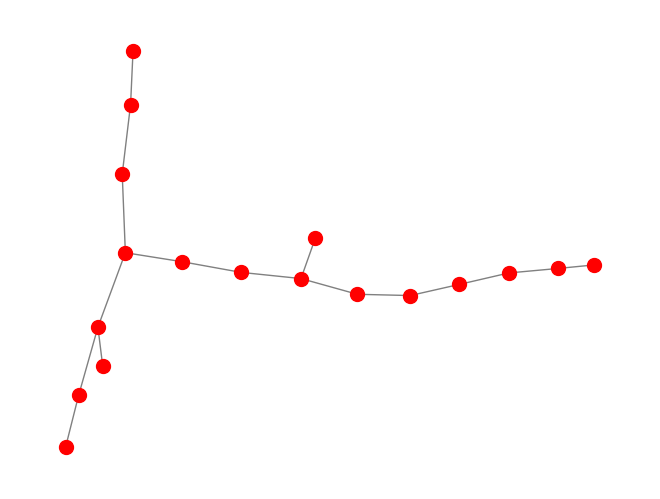

In [17]:
"""
Geração do grafo dual ao polígono triangulado
"""

G = nx.Graph()
triangles_adj_list = TriangleAdjList(triangles_index)
for idx, neighbours in enumerate(triangles_adj_list):
  for neighbour in neighbours:
    G.add_edge(idx, neighbour)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='red', node_size=100, edge_color='gray', font_size=0, font_weight='bold')
plt.show()

In [18]:
"""
Animação da busca em profundidade no grafo dual do polígono triangulado
"""

visited = set()
timestamps = [[np.int64(0), np.int64(0)] for _ in range(len(triangles_index))]
colors = np.int64(np.zeros(len(triangles_index) + 2))
DFS(visited, triangles_adj_list, 0, timestamps)

pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize=(8, 6))

def get_colors(i):
    """
    Dado um tempo i na busca em profundidade, retorna os vértices que estão em cada uma das 3 fases da busca
    """
    white = [idx for idx, time in enumerate(timestamps) if time[0] > i]
    gray = [idx for idx, time in enumerate(timestamps) if time[0] <= i and time[1] > i]
    black = [idx for idx, time in enumerate(timestamps) if time[1] <= i]
    return white, gray, black

def update(num):
    """
    Atualiza a animação com os vértices coloridos de acordo com a fase da busca em profundidade
    """
    ax.clear()

    white, gray, black = get_colors(num)
    white_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=white, node_color="white", ax=ax)
    white_nodes.set_edgecolor("black")
    gray_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=gray, node_color="gray", ax=ax)
    gray_nodes.set_edgecolor("black")
    black_nodes = nx.draw_networkx_nodes(G, pos=pos, nodelist=black, node_color="black", ax=ax)
    black_nodes.set_edgecolor("white")

    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="gray")

    ax.set_title(f"DFS: Passo {num}", fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])


ani = matplotlib.animation.FuncAnimation(fig, update, frames=timestamps[0][1]+1, interval=1000, repeat=True)
ani.save("dfs.gif")
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


### Animação e resultado da 3-Coloração

In [19]:
"""
Animação do processo da 3-coloração do polígono. 
"""

labels_colors = {
    1: 'crimson',
    2: 'chartreuse',
    3: 'goldenrod'
}

previous_colors = {}

fig, ax = plt.subplots(figsize=(10, 10))

def update(idx):
    ax.clear()  
    triangle = triangles[idx]
    x, y, z = triangle
    i, j, k = triangles_index[idx][0], triangles_index[idx][1], triangles_index[idx][2]

    for _, other_triangle in enumerate(triangles):
        if triangle == other_triangle:
            continue
        a, b, c = other_triangle
        ax.scatter(a[0], a[1], color=previous_colors.get(tuple(a), "black"), zorder=2)
        ax.scatter(b[0], b[1], color=previous_colors.get(tuple(b), "black"), zorder=2)
        ax.scatter(c[0], c[1], color=previous_colors.get(tuple(c), "black"), zorder=2)
        ax.plot([a[0], b[0], c[0], a[0]], [a[1], b[1], c[1], a[1]], color="silver", zorder=1)

    current_color_x = labels_colors[colors[i]]
    current_color_y = labels_colors[colors[j]]
    current_color_z = labels_colors[colors[k]]

    previous_colors[tuple(x)] = current_color_x
    previous_colors[tuple(y)] = current_color_y
    previous_colors[tuple(z)] = current_color_z

    ax.scatter(x[0], x[1], color=current_color_x, zorder=2)
    ax.scatter(y[0], y[1], color=current_color_y, zorder=2)
    ax.scatter(z[0], z[1], color=current_color_z, zorder=2)
    ax.plot([x[0], y[0], z[0], x[0]], [x[1], y[1], z[1], x[1]], color="black", zorder=1)
    
    ax.set_title(f"Coloração: Passo {idx}", fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(triangles), repeat=True, interval=1000)
ani.save('coloracao.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [20]:
"""
Animação interativa do processo da 3-coloração do polígono. 
"""

labels_colors = {
    1: 'crimson',
    2: 'chartreuse',
    3: 'goldenrod',
    4: 'slategrey'
}

frames = []
n_frames = 0
previous_colors = {}
triangles_plot_x = [[]]
triangles_plot_y = [[]]
points_color_1_x = [[]]
points_color_1_y = [[]]
points_color_2_x = [[]]
points_color_2_y = [[]]
points_color_3_x = [[]]
points_color_3_y = [[]]

def add_coloring_frame(idx):
    global n_frames
    local_frames = []
    triangle = triangles[idx]
    x, y, z = triangle
    i, j, k = triangles_index[idx]

    current_color_x = labels_colors[colors[i]]
    current_color_y = labels_colors[colors[j]]
    current_color_z = labels_colors[colors[k]]

    previous_colors[tuple(x)] = current_color_x
    previous_colors[tuple(y)] = current_color_y
    previous_colors[tuple(z)] = current_color_z

    # salve as cores dos pontos nos vetores apropriados
    if (current_color_x == labels_colors[1]):
        points_color_1_x.append([x[0]])
        points_color_1_y.append([x[1]])
    elif (current_color_x == labels_colors[2]):
        points_color_2_x.append([x[0]])
        points_color_2_y.append([x[1]])
    else:
        points_color_3_x.append([x[0]])
        points_color_3_y.append([x[1]])
                                
    if (current_color_y == labels_colors[1]):
        points_color_1_x.append([y[0]])
        points_color_1_y.append([y[1]])
    elif (current_color_y == labels_colors[2]):
        points_color_2_x.append([y[0]])
        points_color_2_y.append([y[1]])
    else:
        points_color_3_x.append([y[0]])
        points_color_3_y.append([y[1]])
                                
    if (current_color_z == labels_colors[1]):
        points_color_1_x.append([z[0]])
        points_color_1_y.append([z[1]])
    elif (current_color_z == labels_colors[2]):
        points_color_2_x.append([z[0]])
        points_color_2_y.append([z[1]])
    else:
        points_color_3_x.append([z[0]])
        points_color_3_y.append([z[1]])
           

    local_frames.append(
        go.Frame(data=[
            go.Scatter(
                x=np.concatenate(triangles_plot_x).tolist(),
                y=np.concatenate(triangles_plot_y).tolist(),
                name="Triangles",
                fillcolor="rgba(192,192,192,1)",
                fill="toself",
            ),
            go.Scatter(
                x=[point[0] for point in coordinates] + [coordinates[0][0]],
                y=[point[1] for point in coordinates] + [coordinates[0][1]],
                name="Points",
                mode="lines+markers",
                line=dict(color="rgba(105, 105, 105, 1)"),
            ),
            go.Scatter(
                x=[x[0], y[0], z[0], x[0]],
                y=[x[1], y[1], z[1], x[1]],
                fill="toself",
                name="Current Triangle",
                mode="lines+markers",
                line=dict(color="rgba(0, 255, 0, 1)"),
                fillcolor="rgba(0, 255, 0, 0.5)"
            ),
            go.Scatter(
                x=np.concatenate(points_color_1_x).tolist(),
                y=np.concatenate(points_color_1_y).tolist(),
                mode='markers',
                marker=dict(color=labels_colors[1]),
                name="Red Points"
            ),
            go.Scatter(
                x=np.concatenate(points_color_2_x).tolist(),
                y=np.concatenate(points_color_2_y).tolist(),
                mode='markers',
                marker=dict(color=labels_colors[2]),
                name="Green Points"
            ),
            go.Scatter(
                x=np.concatenate(points_color_3_x).tolist(),
                y=np.concatenate(points_color_3_y).tolist(),
                mode='markers',
                marker=dict(color=labels_colors[3]),
                name="Yellow Points"
            )
        ],
        name=f"frame_{n_frames}")
    )
    n_frames += 1
    
    triangles_plot_x.append([p[0] for p in triangle] + [triangle[0][0]] + [None])
    triangles_plot_y.append([p[1] for p in triangle] + [triangle[0][1]] + [None])
    return local_frames

for idx, _ in enumerate(triangles):
    f = (add_coloring_frame(idx))
    frames += f

fig = go.Figure(
    data=[
        go.Scatter(
            x=[0, 0], y=[0, 0], 
            name="Triangles",
            line=dict(color="rgba(105, 105, 105, 1)")
        ),
        go.Scatter(
            x=[point[0] for point in coordinates] + [coordinates[0][0]],
            y=[point[1] for point in coordinates] + [coordinates[0][1]],
            name="Points",
            mode="lines+markers",
            line=dict(color="rgba(105, 105, 105, 1)"),
        ),
        go.Scatter(x=[0, 0], y=[0, 0], name="Current Triangle"),
        go.Scatter(x=[0, 0], y=[0, 0], name="Red Points"),
        go.Scatter(x=[0, 0], y=[0, 0], name="Green Points"),
        go.Scatter(x=[0, 0], y=[0, 0], name="Yellow Points"),
    ],
    layout=go.Layout(
        xaxis=dict(range=[min([p[0] for t in triangles for p in t])-10, max([p[0] for t in triangles for p in t])+10], autorange=False),
        yaxis=dict(range=[min([p[1] for t in triangles for p in t])-10, max([p[1] for t in triangles for p in t])+10], autorange=False),
        title="Triangle Coloring - Execution",
        updatemenus=[dict(
            buttons=[
                dict(
                    args=[None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True}],
                    label="Play",
                    method="animate"
                ),
                dict(
                    args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}],
                    label="Pause",
                    method="animate"
                ),
                dict(
                    label="Slow",
                    method="animate",
                    args=[None, dict(frame=dict(duration=500, redraw=True), fromcurrent=True, transition=dict(duration=0))]
                )
            ],
        )]
    ),
    frames=frames,
)

# Adicionar sliders
sliders = [dict(steps=[dict(method='animate',
                             args=[[f'frame_{k}'],
                                   dict(mode='immediate',
                                        frame=dict(duration=2000, redraw=True),
                                        transition=dict(duration=0))
                                  ],
                             label=f'Slide {k+1}'
                            ) for k in range(len(frames))],
               active=0,
               transition=dict(duration=0),
               currentvalue=dict(font=dict(size=12),
                                 visible=True,
                                 xanchor='center'
                                ),
               len=1.0)
          ]

fig.update_layout(width=1200, height=800, sliders=sliders, template="plotly_dark")
fig.write_html("jnd.html", full_html=False, include_plotlyjs='cdn')

# Exibir a figura
fig.show()


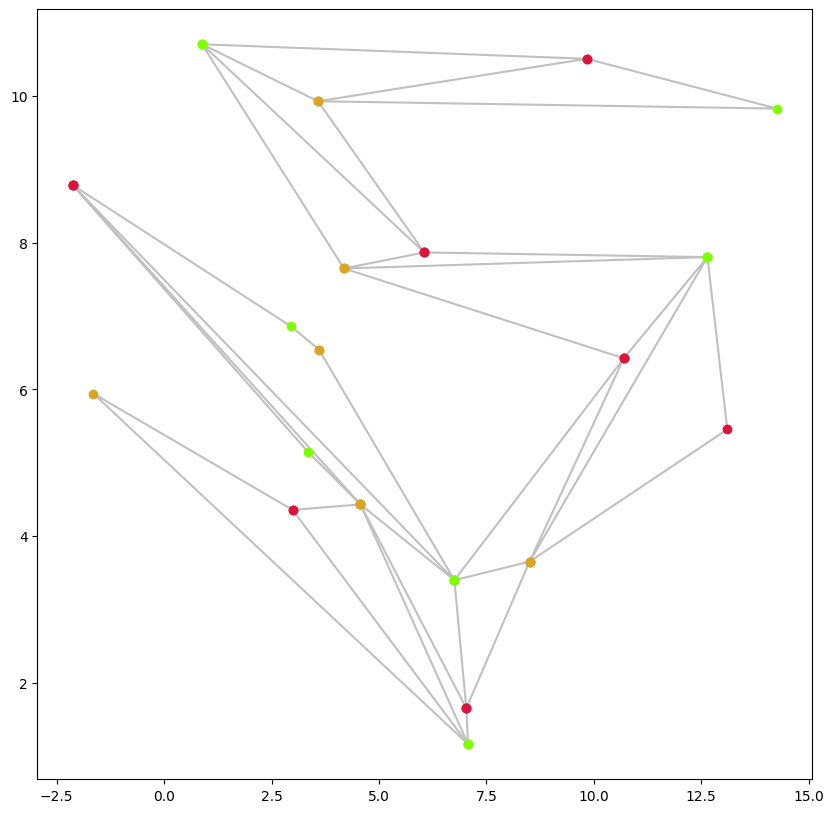

In [21]:
"""
Resultado do processo da 3-coloração do polígono. 
"""

plt.figure(figsize=(10, 10))  
for idx, triangle in enumerate(triangles):
  x, y, z = triangle
  i, j, k = triangles_index[idx][0], triangles_index[idx][1], triangles_index[idx][2]

  plt.scatter(x[0], x[1], color = labels_colors[colors[i]], zorder=2)
  plt.scatter(y[0], y[1], color = labels_colors[colors[j]], zorder=2)
  plt.scatter(z[0], z[1], color = labels_colors[colors[k]], zorder=2)
  plt.plot([x[0], y[0], z[0]], [x[1], y[1], z[1]], color = "silver", zorder=1)
plt.show()  

### Posicionamento das câmeras no polígono

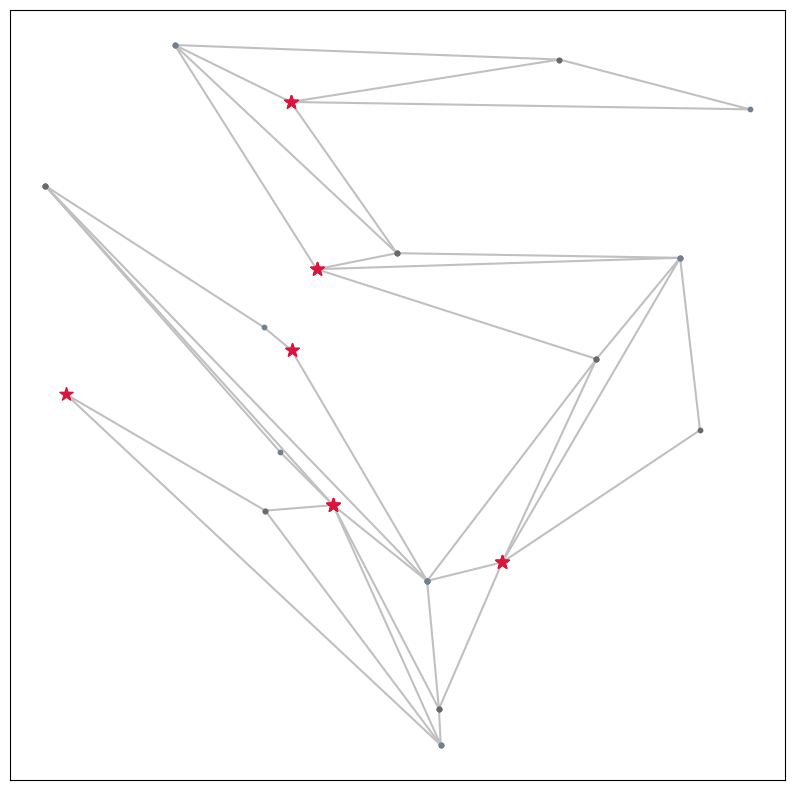

In [22]:
"""
Disposição final das câmeras no polígono. 
"""

from collections import Counter

def get_labels_colors(color):
  """
  Retorna as cores dos vértices de acordo com a cor da câmera
  """
  if color == 1:
    return {1: 'crimson', 2: 'dimgray', 3: 'slategray'}
  if color == 2:
    return {1: 'dimgray', 2: 'crimson', 3: 'slategray'}
  if color == 3:
    return {1: 'dimgray', 2: 'slategray', 3: 'crimson'}

def get_labels_markers(color):
  """
  Retorna os marcadores dos vértices de acordo com a cor da câmera
  """
  if color == 1:
    return {1: '*', 2: 'o', 3: 'o'}
  if color == 2:
    return {1: 'o', 2: '*', 3: 'o'}
  if color == 3:
    return {1: 'o', 2: 'o', 3: '*'}
  
def get_markers_size(color):
  """
  Retorna o tamanho dos marcadores dos vértices de acordo com a cor da câmera
  """
  if color == 1:
    return {1: 100, 2: 10, 3: 10}
  if color == 2:
    return {1: 10, 2: 100, 3: 10}
  if color == 3:
    return {1: 10, 2: 10, 3: 100}

plt.figure(figsize=(10, 10))
for idx, triangle in enumerate(triangles):
  x, y, z = triangle
  i, j, k = triangles_index[idx][0], triangles_index[idx][1], triangles_index[idx][2]

  camera_color = Counter(colors).most_common()[-1][0] # A cor da câmera é a cor menos utilizada
  labels_colors = get_labels_colors(camera_color)
  labels_markers = get_labels_markers(camera_color)
  labels_markers_size = get_markers_size(camera_color)
  
  plt.scatter(x[0], x[1], color = labels_colors[colors[i]], zorder=2, marker=labels_markers[colors[i]], s=labels_markers_size[colors[i]])
  plt.scatter(y[0], y[1], color = labels_colors[colors[j]], zorder=2, marker=labels_markers[colors[j]], s=labels_markers_size[colors[j]])
  plt.scatter(z[0], z[1], color = labels_colors[colors[k]], zorder=2, marker=labels_markers[colors[k]], s=labels_markers_size[colors[k]])
  plt.plot([x[0], y[0], z[0]], [x[1], y[1], z[1]], color = "silver", zorder=1)
  plt.xticks([])
  plt.yticks([])

plt.show()